#TODO:
- use logarythmic values (revise course) X
- feature engineering
- use hyperopt
- XGBoost learning curves (lesson 3.2) X
- General refactor
- Feature importances + eli5
- Other methods?

In [ ]:
#plt.hist(y_test - y_pred) #rozklad bledow

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

from scikitplot.estimators import plot_learning_curve
np.random.seed(2020)

%matplotlib inline

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.sample(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
236,88299702,M,23.21,26.97,153.50,1670.0,0.09509,0.1682,0.19500,0.12370,...,34.51,206.00,2944.0,0.14810,0.4126,0.5820,0.25930,0.3103,0.08677,NaN
106,863031,B,11.64,18.33,75.17,412.5,0.11420,0.1017,0.07070,0.03485,...,29.26,85.51,521.7,0.16880,0.2660,0.2873,0.12180,0.2806,0.09097,NaN
284,8912284,B,12.89,15.70,84.08,516.6,0.07818,0.0958,0.11150,0.03390,...,19.69,92.12,595.6,0.09926,0.2317,0.3344,0.10170,0.1999,0.07127,NaN
262,888570,M,17.29,22.13,114.40,947.8,0.08999,0.1273,0.09697,0.07507,...,27.24,137.90,1295.0,0.11340,0.2867,0.2298,0.15280,0.3067,0.07484,NaN
356,9010259,B,13.05,18.59,85.09,512.0,0.10820,0.1304,0.09603,0.05603,...,24.85,94.22,591.2,0.13430,0.2658,0.2573,0.12580,0.3113,0.08317,NaN
544,922297,B,13.87,20.70,89.77,584.8,0.09578,0.1018,0.03688,0.02369,...,24.75,99.17,688.6,0.12640,0.2037,0.1377,0.06845,0.2249,0.08492,NaN
280,8912049,M,19.16,26.60,126.20,1138.0,0.10200,0.1453,0.19210,0.09664,...,35.90,159.80,1724.0,0.17820,0.3841,0.5754,0.18720,0.3258,0.09720,NaN
430,907914,M,14.90,22.53,102.10,685.0,0.09947,0.2225,0.27330,0.09711,...,27.57,125.40,832.7,0.14190,0.7090,0.9019,0.24750,0.2866,0.11550,NaN
121,86517,M,18.66,17.12,121.40,1077.0,0.10540,0.1100,0.14570,0.08665,...,24.90,145.40,1549.0,0.15030,0.2291,0.3272,0.16740,0.2894,0.08456,NaN
487,913505,M,19.44,18.82,128.10,1167.0,0.10890,0.1448,0.22560,0.11940,...,30.39,153.90,1740.0,0.15140,0.3725,0.5936,0.20600,0.3266,0.09009,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

In [5]:
data.diagnosis.value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [6]:
log_feats = ['area_mean', 'area_se', 'area_worst', 'compactness_mean', 'compactness_se', 'compactness_worst', 'concave points_mean', 
             'concave points_se', 'concave points_worst', 'concavity_mean', 'concavity_se', 'concavity_worst', 'fractal_dimension_mean',
             'fractal_dimension_se', 'fractal_dimension_worst', 'perimeter_mean', 'perimeter_se', 'perimeter_worst', 'radius_mean', 'radius_se',
            'radius_worst', 'smoothness_se', 'symmetry_se', 'symmetry_worst', 'texture_se']

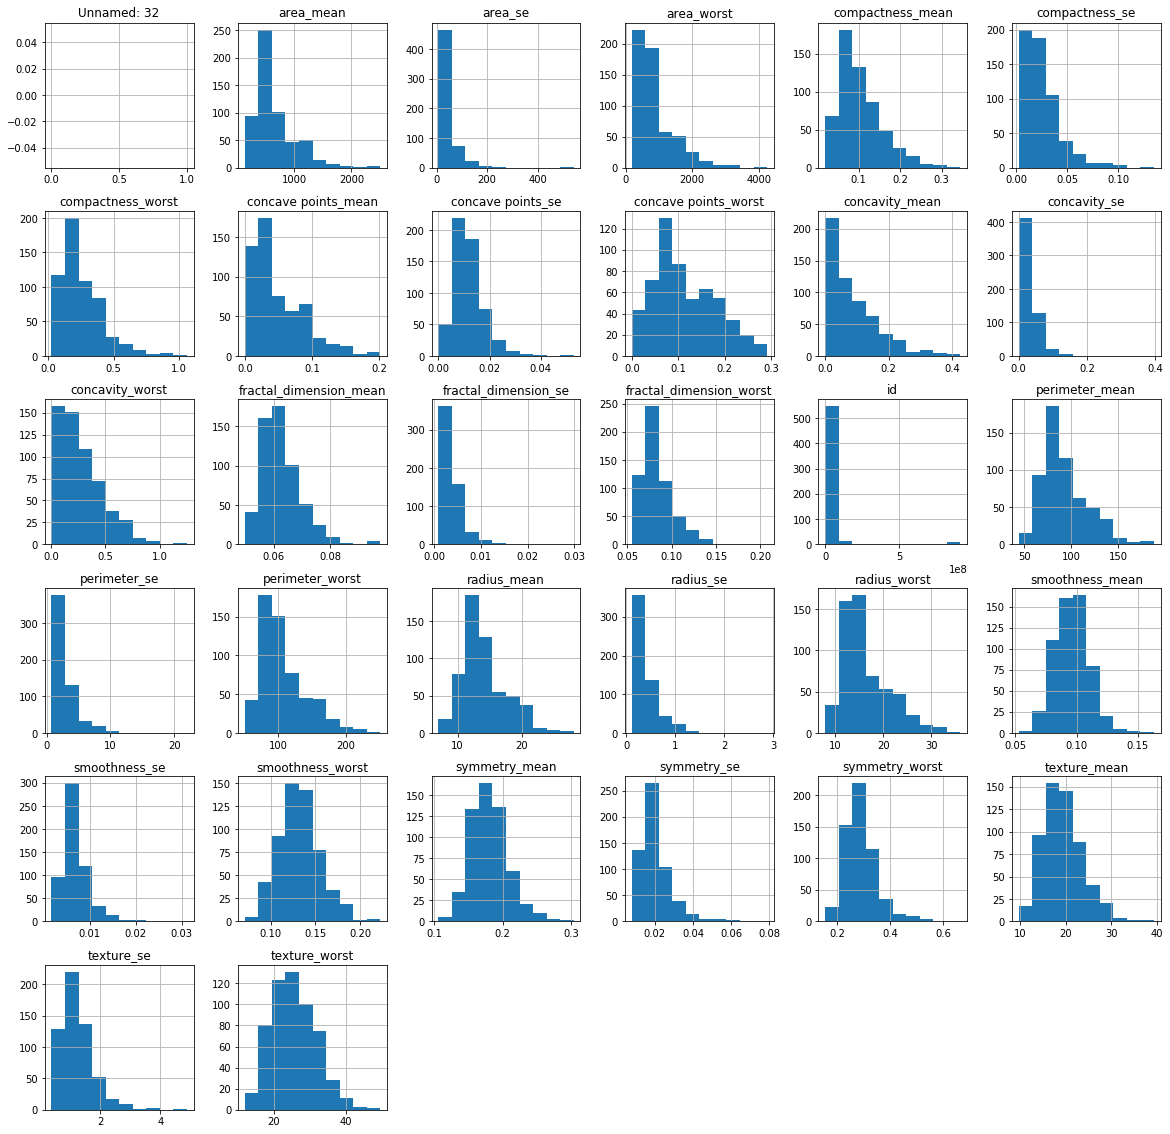

In [7]:
data.hist(figsize=(20, 20));

In [33]:
def prepare_and_train_models(models):
    X = data[:]
    del X['id']
    del X['Unnamed: 32']
    del X['diagnosis']

    X = X.values
    y = np.array([1 if el=='M' else 0 for el in data['diagnosis']])

    models = [
        {
            'name': 'DecisionTreeClassifier',
            'model': DecisionTreeClassifier(min_samples_leaf=5, random_state=2020)
        },
        {
            'name': 'RandomForestClassifier',
            'model': RandomForestClassifier(n_estimators=100, min_samples_leaf=5, random_state=2020)
        },
        {
            'name': 'XGBoostClassifier',
            'model': XGBClassifier(random_state=2020)
        },
    ]

    cv = KFold(n_splits=5, shuffle=True, random_state=2020)

    for model in models:
        scores = []
        for train_ids, test_ids in cv.split(X, y):
            model['model'].fit(X[train_ids], y[train_ids])
            y_pred = model['model'].predict(X[test_ids])
            score = accuracy_score(y[test_ids], y_pred)
            scores.append(score)

        print(model['name'], np.mean(scores), np.std(scores))

In [35]:
prepare_and_train_models(models)

DecisionTreeClassifier 0.9297624592454587 0.024092586041573407
RandomForestClassifier 0.956078248719143 0.015657443095151165
XGBoostClassifier 0.9630957925787922 0.015085089089243027


In [28]:
for feat in log_feats:
    X['{}_log'.format(feat)] = np.log10(X[feat] +100)

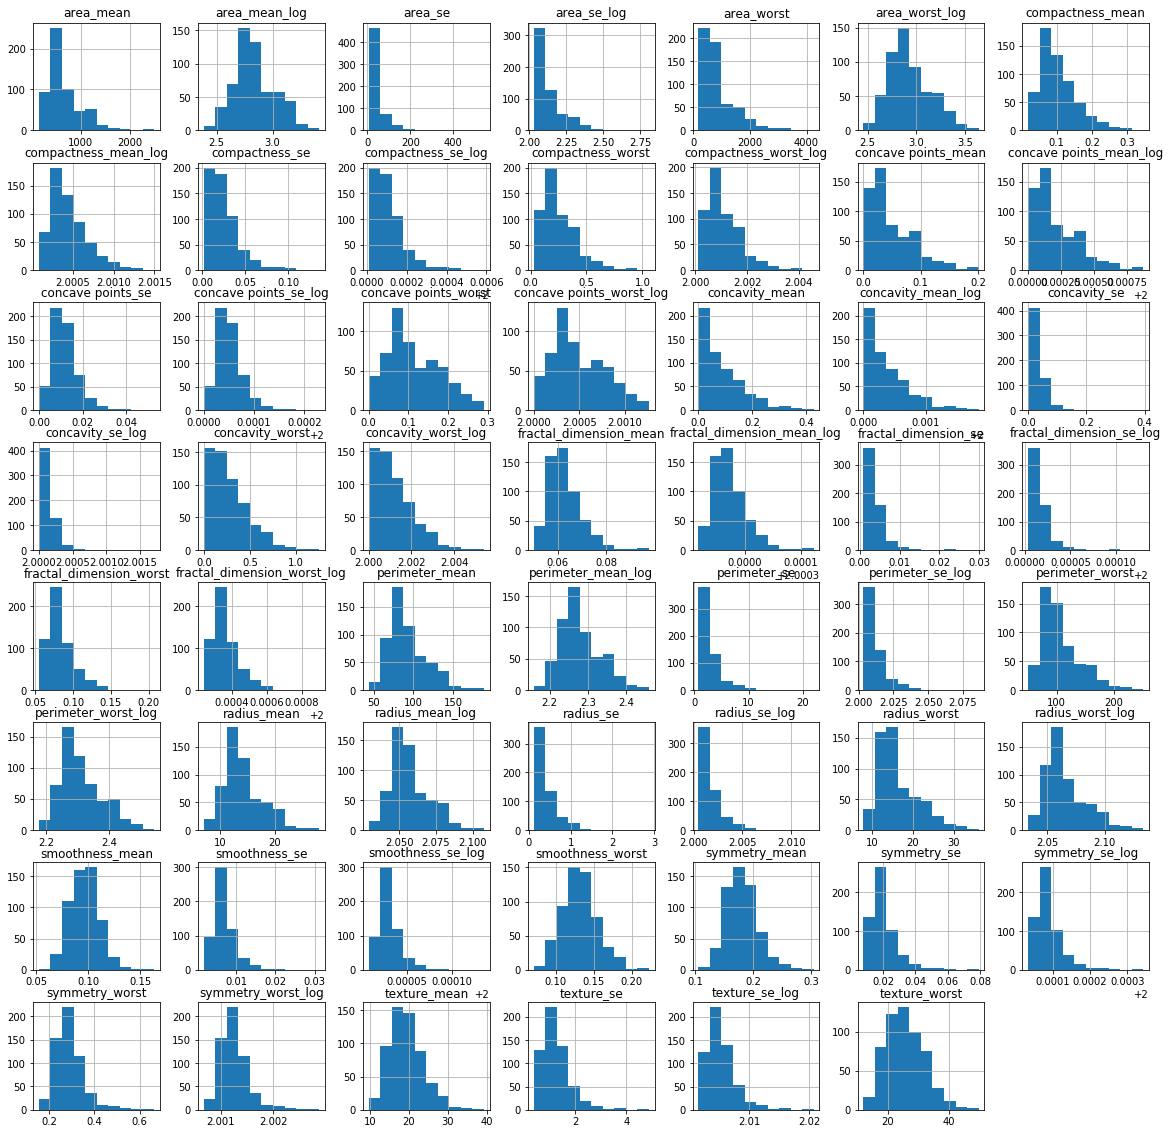

In [29]:
X.hist(figsize=(20, 20));

In [36]:
prepare_and_train_models(models)

DecisionTreeClassifier 0.9297624592454587 0.024092586041573407
RandomForestClassifier 0.956078248719143 0.015657443095151165
XGBoostClassifier 0.9630957925787922 0.015085089089243027
